<a href="https://colab.research.google.com/github/saraires/Proyecto-Modelos1/blob/main/99_modelo_soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extrayendo Información desde Kaggle

# **99 - modelo solución**
### Santiago Palacio Cárdenas
### Sarai Restrepo Rodríguez
### Natalia Bernal Gutiérrez

En este notebook desarrollamos un modelo de clasificación supervisada para predecir el rendimiento global de los estudiantes en las pruebas Saber Pro, utilizando técnicas avanzadas de ingeniería de características y un modelo CatBoost optimizado para datos categóricos. A lo largo del flujo, realizamos el procesamiento del conjunto de entrenamiento, entrenamos el modelo en fase de validación para evaluar su desempeño y finalmente construimos un modelo definitivo con todos los datos disponibles para generar el archivo de envío requerido por Kaggle. Este notebook documenta de manera clara cada paso del proceso para garantizar reproducibilidad, trazabilidad y comprensión del pipeline completo.


# **1. Extrayendo Información desde Kaggle**

En esta sección descargamos los archivos oficiales de la competencia directamente desde Kaggle usando la interfaz de línea de comandos, lo cual nos permite obtener las versiones más recientes del conjunto de entrenamiento, prueba y ejemplos de envío. Esta descarga garantiza que trabajemos con los datos proporcionados por la competencia sin modificaciones locales y mantiene la coherencia entre el entorno de trabajo y la plataforma de evaluación. Además, dejar explícito el comando de extracción permite que cualquier persona que abra el notebook pueda replicar el proceso fácilmente.

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.63GB/s]


In [ ]:
!unzip udea*.zip > /dev/null
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185238 test.csv
   692501  10666231 143732437 train.csv
  1286075  15528571 207634348 total


# **2. Importaciones e instalaciones necesarias**

En esta sección instalamos y cargamos todas las librerías esenciales que utilizaremos a lo largo del desarrollo del modelo. Primero instalamos CatBoost, un algoritmo altamente eficiente para manejar grandes cantidades de variables categóricas y adecuado para problemas de clasificación multiclase como el rendimiento Saber Pro. Luego importamos herramientas de manejo de datos como pandas y numpy, junto con funciones de scikit-learn para realizar particiones, métricas de evaluación y manejo de pools de datos. Finalmente, cargamos librerías de visualización como matplotlib y seaborn, que nos permitirán analizar el comportamiento del modelo a través de gráficas como la matriz de confusión y las curvas de aprendizaje. Estas importaciones preparan el entorno completo para ejecutar todo el pipeline de principio a fin.




In [ ]:
!pip install catboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns

# **3. Definición de la Clase del Modelo**

En esta sección definimos la clase encargada de todo el proceso de construcción del modelo de predicción, incluyendo el preprocesamiento, la ingeniería de características, el entrenamiento y la generación de predicciones finales. Esta clase agrupa de manera modular y organizada todas las funciones necesarias para limpiar los datos, transformar variables categóricas, realizar codificación basada en el rendimiento histórico, crear nuevas características socioeconómicas y educativas, entrenar el modelo CatBoost y producir los resultados en el formato requerido por Kaggle. Centralizar el pipeline dentro de una clase permite mantener el código más limpio, reutilizable y fácil de depurar, además de facilitar la ejecución tanto del modelo de validación como del modelo final entrenado con todos los datos disponibles.


In [ ]:
class StudentPerformanceClassifier:

    def __init__(self):
        self.model = None
        self.feature_importance = None
        self.target_encodings = {}
        self.training_columns = []
        self.categorical_features = []
        self.evals_result = None
        self.df_train = None

    # -----------------------------------------------------------
    # Convertir rendimiento a número
    # -----------------------------------------------------------
    def rendimiento_to_numeric(self, rendimiento):
        mapping = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
        return mapping.get(rendimiento)

    # -----------------------------------------------------------
    # Target encoding: programa y departamento
    # -----------------------------------------------------------
    def create_location_program_features(self, df, target_df=None):

        if target_df is not None:
            target_df = target_df.copy()
            target_df["RENDIMIENTO_NUM"] = target_df["RENDIMIENTO_GLOBAL"].map(self.rendimiento_to_numeric)

            prog_stats = target_df.groupby("E_PRGM_ACADEMICO")["RENDIMIENTO_NUM"].agg(["mean", "std", "size"])
            prog_stats.columns = ["PROG_RENDIMIENTO_MEDIO", "PROG_RENDIMIENTO_STD", "PROG_COUNT"]

            dept_stats = target_df.groupby("E_PRGM_DEPARTAMENTO")["RENDIMIENTO_NUM"].agg(["mean", "std", "size"])
            dept_stats.columns = ["DEPT_RENDIMIENTO_MEDIO", "DEPT_RENDIMIENTO_STD", "DEPT_COUNT"]

            self.target_encodings["programa"] = prog_stats
            self.target_encodings["departamento"] = dept_stats

        # Merge programa
        if "programa" in self.target_encodings:
            df = df.merge(self.target_encodings["programa"], how="left", on="E_PRGM_ACADEMICO")

        # Merge departamento
        if "departamento" in self.target_encodings:
            df = df.merge(self.target_encodings["departamento"], how="left", on="E_PRGM_DEPARTAMENTO")

        df[["PROG_RENDIMIENTO_MEDIO", "PROG_RENDIMIENTO_STD", "PROG_COUNT"]] = \
            df[["PROG_RENDIMIENTO_MEDIO", "PROG_RENDIMIENTO_STD", "PROG_COUNT"]].fillna(0)

        df[["DEPT_RENDIMIENTO_MEDIO", "DEPT_RENDIMIENTO_STD", "DEPT_COUNT"]] = \
            df[["DEPT_RENDIMIENTO_MEDIO", "DEPT_RENDIMIENTO_STD", "DEPT_COUNT"]].fillna(0)

        return df

    # -----------------------------------------------------------
    # Features educativas
    # -----------------------------------------------------------
    def create_education_features(self, df):

        mapping = {
            'Ninguno': 0,
            'Primaria incompleta': 1,
            'Primaria completa': 2,
            'Secundaria (Bachillerato) incompleta': 3,
            'Secundaria (Bachillerato) completa': 4,
            'Técnica o tecnológica incompleta': 5,
            'Técnica o tecnológica completa': 6,
            'Educación profesional incompleta': 7,
            'Educación profesional completa': 8,
            'Postgrado': 9,
            'No reporta': 4
        }

        df["FAMI_EDUCACIONPADRE_NUM"] = df["F_EDUCACIONPADRE"].map(mapping)
        df["FAMI_EDUCACIONMADRE_NUM"] = df["F_EDUCACIONMADRE"].map(mapping)

        df["FAMI_EDUCACION_PROMEDIO"] = (
            df["FAMI_EDUCACIONPADRE_NUM"] + df["FAMI_EDUCACIONMADRE_NUM"]
        ) / 2

        df["FAMI_EDUCACION_DIFERENCIA"] = abs(
            df["FAMI_EDUCACIONPADRE_NUM"] - df["FAMI_EDUCACIONMADRE_NUM"]
        )

        df["FAMI_EDUCACION_MAX"] = df[["FAMI_EDUCACIONPADRE_NUM", "FAMI_EDUCACIONMADRE_NUM"]].max(axis=1)
        df["FAMI_EDUCACION_MIN"] = df[["FAMI_EDUCACIONPADRE_NUM", "FAMI_EDUCACIONMADRE_NUM"]].min(axis=1)

        return df

    # -----------------------------------------------------------
    # Features económicas según dataset REAL
    # -----------------------------------------------------------
    def create_economic_features(self, df):

        estrato_mapping = {
            "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6,
            "No reporta": 3
        }

        matricula_mapping = {
            'Menos de 500 mil': 0,
            'Entre 500 mil y menos de 1 millón': 1,
            'Entre 1 millón y menos de 2.5 millones': 2,
            'Entre 2.5 millones y menos de 4 millones': 3,
            'Entre 4 millones y menos de 5.5 millones': 4,
            'Entre 5.5 millones y menos de 7 millones': 5,
            'Más de 7 millones': 6,
            'No reporta': 3
        }

        df["FAMI_ESTRATO_NUM"] = df["F_ESTRATOVIVIENDA"].map(estrato_mapping)
        df["MATRICULA_NUM"] = df["E_VALORMATRICULAUNIVERSIDAD"].map(matricula_mapping)

        df["INTERNET_BIN"] = (df["F_TIENEINTERNET"] == "Si").astype(int)

        df["SCORE_SOCIOECONOMICO"] = (
            df["FAMI_ESTRATO_NUM"] * 0.4
            + df["MATRICULA_NUM"] * 0.4
            + df["INTERNET_BIN"] * 0.2
        )

        return df

    # -----------------------------------------------------------
    # Preprocesamiento común
    # -----------------------------------------------------------
    def _preprocess_common(self, df):

        cols_to_drop = [
            "ID",
            "INDICADOR_1",
            "INDICADOR_2",
            "INDICADOR_3",
            "INDICADOR_4",
            "F_TIENEINTERNET.1"
        ]

        X = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors="ignore").copy()

        y = None
        if "RENDIMIENTO_GLOBAL" in X.columns:
            y = X.pop("RENDIMIENTO_GLOBAL")

        # Rellenar NaNs de categóricas
        for col in X.select_dtypes(include=["object"]).columns:
            X[col] = X[col].fillna("No reporta")

        # Convertir periodo a string
        if "PERIODO_ACADEMICO" in X.columns:
            X["PERIODO_ACADEMICO"] = X["PERIODO_ACADEMICO"].astype(str)

        X = self.create_education_features(X)
        X = self.create_economic_features(X)

        return X, y

    # -----------------------------------------------------------
    # Preprocesamiento completo
    # -----------------------------------------------------------
    def preprocess_data(self, data, validation_mode=True):

        X, y = self._preprocess_common(data)

        if validation_mode:

            print("Modo: Validación (dividiendo datos)")

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )

            train_target_df = X_train.copy()
            train_target_df["RENDIMIENTO_GLOBAL"] = y_train

            X_train = self.create_location_program_features(X_train, train_target_df)
            X_test = self.create_location_program_features(X_test)

            self.df_train = X_train.copy()
            self.training_columns = X_train.columns
            self.categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

            return (
                Pool(X_train, y_train, cat_features=self.categorical_features),
                Pool(X_test, y_test, cat_features=self.categorical_features)
            )

        else:
            print("Modo: Entrenamiento final")

            df_target = pd.concat([X, y.rename("RENDIMIENTO_GLOBAL")], axis=1)
            X = self.create_location_program_features(X, df_target)

            self.df_train = X.copy()
            self.training_columns = X.columns
            self.categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

            return Pool(X, y, cat_features=self.categorical_features)

    # -----------------------------------------------------------
    # Entrenamiento
    # -----------------------------------------------------------
    def train_model(self, train_pool, eval_pool=None):

        self.model = CatBoostClassifier(
            iterations=3000,
            loss_function='MultiClass',
            eval_metric='Accuracy',
            random_seed=42,
            task_type='GPU',
            verbose=100,
            early_stopping_rounds=50,
            learning_rate=0.03322175851979197,
            depth=8,
            l2_leaf_reg=10.46509730642616,
            bootstrap_type='Bayesian',
            bagging_temperature=0.4868502171372011,
            one_hot_max_size=10,
            leaf_estimation_method='Newton'
        )

        self.model.fit(
            train_pool,
            eval_set=eval_pool,
            use_best_model=bool(eval_pool)
        )

        if eval_pool is not None:
            self.evals_result = self.model.get_evals_result()

        self.feature_importance = self.model.get_feature_importance(train_pool)

    def plot_learning_curve(self):

        if self.evals_result is None:
            print("No hay resultados de evaluación. Entrena con validation_mode=True.")
            return

        results = self.evals_result
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Accuracy
        ax1.plot(results['learn']['Accuracy'], label='Train Accuracy')
        ax1.plot(results['validation']['Accuracy'], label='Validation Accuracy')
        ax1.legend()
        ax1.set_title('Accuracy Curve')
        ax1.set_xlabel('Iterations')

        # Loss
        ax2.plot(results['learn']['MultiClass'], label='Train Loss')
        ax2.plot(results['validation']['MultiClass'], label='Validation Loss')
        ax2.legend()
        ax2.set_title('Loss Curve')
        ax2.set_xlabel('Iterations')

        plt.tight_layout()
        plt.show()

    # -----------------------------------------------------------
    # Evaluación
    # -----------------------------------------------------------
    def evaluate_model(self, test_pool):

        if self.model is None:
            print("El modelo no ha sido entrenado.")
            return None, None

        predictions = self.model.predict(test_pool)
        y_true = test_pool.get_label()

        report = classification_report(y_true, predictions, target_names=self.model.classes_)
        cm = confusion_matrix(y_true, predictions, labels=self.model.classes_)

        return report, cm

    # -----------------------------------------------------------
    # Predicción final
    # -----------------------------------------------------------
    def predict(self, X_test_df):

        if self.model is None:
            raise ValueError("El modelo debe ser entrenado primero.")

        X_test, _ = self._preprocess_common(X_test_df)
        X_test = self.create_location_program_features(X_test)

        X_test = X_test.reindex(columns=self.training_columns, fill_value=0)

        return self.model.predict(X_test)

    # -----------------------------------------------------------
    # Guardar submission
    # -----------------------------------------------------------
    def save_predictions(self, X_test_df, filename):

        preds = self.predict(X_test_df)

        df = pd.DataFrame({
            "ID": X_test_df["ID"],
            "RENDIMIENTO_GLOBAL": preds.flatten()
        })

        df.to_csv(filename, index=False)
        print(f"Archivo guardado como {filename}")

        return df


# **4. Uso de la Clase**

En esta sección utilizamos la clase previamente definida para ejecutar el flujo completo de validación del modelo, comenzando por cargar el dataset de entrenamiento, aplicar todo el proceso de preprocesamiento y generar los conjuntos de datos internos que CatBoost requiere (train_pool y test_pool). Luego se instancia el clasificador, se divide la información en datos de entrenamiento y validación y se entrena el modelo activando técnicas como early stopping gracias al uso del eval_pool. Este paso nos permite verificar el comportamiento real del modelo antes de entrenar la versión final, analizar su rendimiento, revisar las curvas de aprendizaje y validar que todos los componentes del pipeline —como la ingeniería de características, las codificaciones y los parámetros del modelo— están funcionando correctamente antes de continuar con el entrenamiento final y la creación del archivo de envío para Kaggle.


In [ ]:
# Cargar datos
data = pd.read_csv('train.csv')

In [ ]:
# Instanciar el clasificador
print("=== Iniciando Fase de Validación ===")
classifier = StudentPerformanceClassifier()

=== Iniciando Fase de Validación ===


In [ ]:
# Preprocesamiento en modo validación
train_pool, test_pool = classifier.preprocess_data(
    data,
    validation_mode=True
)

Modo: Validación (dividiendo datos)


In [ ]:
# Entrenamiento del modelo con eval_pool para activar early stopping
print("\n=== Entrenando modelo de validación... ===")
classifier.train_model(train_pool, eval_pool=test_pool)
print("=== Entrenamiento completado ===")


=== Entrenando modelo de validación... ===
0:	learn: 0.4029964	test: 0.4017762	best: 0.4017762 (0)	total: 73.8ms	remaining: 3m 41s
100:	learn: 0.4320397	test: 0.4280217	best: 0.4280217 (100)	total: 3.11s	remaining: 1m 29s
200:	learn: 0.4394531	test: 0.4338845	best: 0.4339928 (198)	total: 5.91s	remaining: 1m 22s
300:	learn: 0.4436101	test: 0.4369819	best: 0.4370830 (299)	total: 8.75s	remaining: 1m 18s
400:	learn: 0.4465596	test: 0.4385560	best: 0.4386354 (389)	total: 13.4s	remaining: 1m 26s
500:	learn: 0.4493051	test: 0.4392491	best: 0.4393285 (496)	total: 16.3s	remaining: 1m 21s
600:	learn: 0.4515921	test: 0.4402599	best: 0.4403538 (582)	total: 19.1s	remaining: 1m 16s
700:	learn: 0.4535903	test: 0.4411552	best: 0.4411552 (700)	total: 23.6s	remaining: 1m 17s
800:	learn: 0.4554206	test: 0.4415379	best: 0.4415379 (800)	total: 26.5s	remaining: 1m 12s
900:	learn: 0.4570812	test: 0.4420072	best: 0.4420578 (897)	total: 29.4s	remaining: 1m 8s
1000:	learn: 0.4584856	test: 0.4424765	best: 0.442


=== Curvas de aprendizaje ===


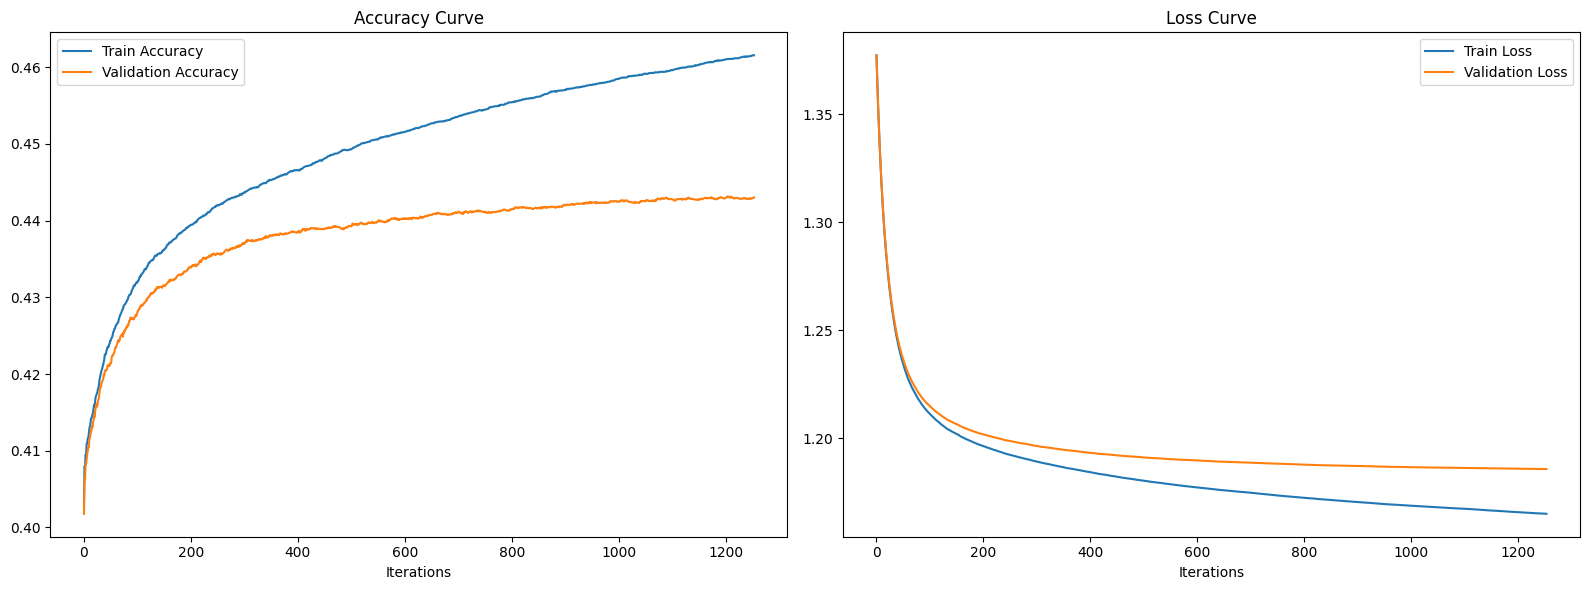

In [ ]:
# Graficar curvas de aprendizaje
print("\n=== Curvas de aprendizaje ===")
classifier.plot_learning_curve()

In [ ]:
# Ver la forma final de los datos preprocesados
classifier.df_train.head()


,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,...,FAMI_ESTRATO_NUM,MATRICULA_NUM,INTERNET_BIN,SCORE_SOCIOECONOMICO,PROG_RENDIMIENTO_MEDIO,PROG_RENDIMIENTO_STD,PROG_COUNT,DEPT_RENDIMIENTO_MEDIO,DEPT_RENDIMIENTO_STD,DEPT_COUNT
0,20183,CONTADURIA PUBLICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Más de 30 horas,Estrato 2,Si,Secundaria (Bachillerato) incompleta,Si,Si,...,NaN,2.0,1,NaN,1.194281,1.013860,31650,1.557140,1.126421,225588
1,20212,FILOSOFIA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,No reporta,No reporta,No reporta,No reporta,No reporta,No reporta,...,3.0,2.0,0,2.0,2.087894,1.070863,603,1.557140,1.126421,225588
2,20203,INGENIERIA DE SOFTWARE,BOGOTÁ,Entre 4 millones y menos de 5.5 millones,Entre 21 y 30 horas,Estrato 2,Si,No sabe,Si,Si,...,NaN,4.0,1,NaN,1.322936,1.143366,545,1.557140,1.126421,225588
3,20183,ADMINISTRACIÓN EN SALUD OCUPACIONAL,ATLANTICO,Entre 500 mil y menos de 1 millón,Entre 11 y 20 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,...,NaN,1.0,1,NaN,0.662745,0.819791,8839,1.462676,1.135028,32794
4,20183,DERECHO,CAUCA,Entre 2.5 millones y menos de 4 millones,0,Estrato 1,Si,Primaria incompleta,Si,No,...,NaN,3.0,1,NaN,1.628156,1.113495,42456,1.269965,1.074659,9216


# **5. Evaluación del Modelo en Fase de Validación**

En esta sección evaluamos el rendimiento del modelo entrenado durante la fase de validación, utilizando exclusivamente el conjunto de datos reservado como test interno para medir la capacidad real de generalización. A partir de las predicciones generadas por el modelo, calculamos métricas clave como precisión, recall, f1-score y accuracy, lo que nos permite identificar el comportamiento del clasificador en cada una de las clases objetivo del rendimiento académico. Asimismo, construimos y visualizamos la matriz de confusión para detectar patrones de error, especialmente la forma en que el modelo distingue entre categorías como medio-alto y medio-bajo, que suelen presentar mayor confusión. Esta evaluación es fundamental para validar que la ingeniería de características, las codificaciones y los parámetros del modelo están funcionando correctamente antes de proceder al entrenamiento final con todos los datos disponibles.



=== Reporte de Clasificación ===
              precision    recall  f1-score   support

        alto       0.56      0.63      0.59     35124
        bajo       0.47      0.58      0.52     34597
  medio-alto       0.34      0.29      0.31     34324
  medio-bajo       0.34      0.27      0.30     34455

    accuracy                           0.44    138500
   macro avg       0.43      0.44      0.43    138500
weighted avg       0.43      0.44      0.43    138500


=== Matriz de Confusión ===


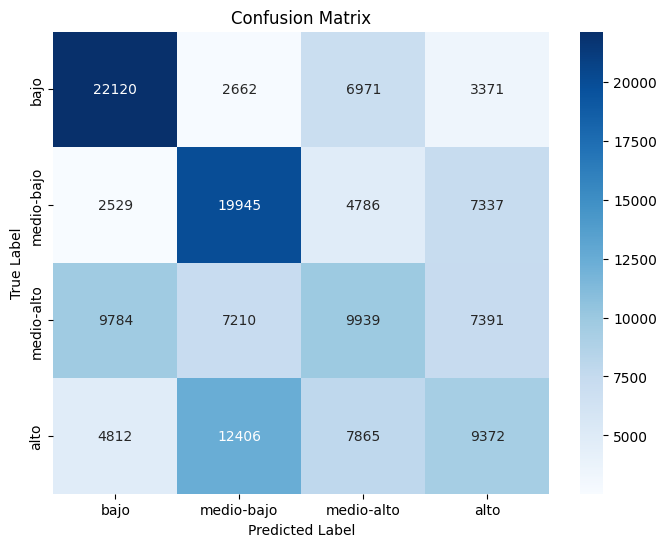

In [ ]:
report, cm = classifier.evaluate_model(test_pool)

# Nombres reales de las clases
label_names = ['bajo', 'medio-bajo', 'medio-alto', 'alto']

print("\n=== Reporte de Clasificación ===")
print(report)

In [ ]:
print("\n=== Matriz de Confusión ===")
plt.figure(figsize=(8, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **6. Entrenamiento Final y Generación de Predicciones para Kaggle**

En esta etapa realizamos el entrenamiento final del modelo utilizando el 100% de los datos disponibles en el archivo *train.csv*, sin dividir en validación, con el fin de maximizar la capacidad de aprendizaje del clasificador antes de generar las predicciones oficiales para el reto de Kaggle. Primero se preprocesa nuevamente todo el dataset completo, aplicando la misma ingeniería de características, codificaciones y transformaciones que se emplearon en la fase de validación, garantizando consistencia entre el modelo final y las pruebas anteriores. Una vez entrenado el modelo final, cargamos el archivo *test.csv*, aplicamos el preprocesamiento correspondiente y generamos las etiquetas de rendimiento para cada estudiante, produciendo finalmente el archivo *my_submission.csv* en el formato exacto exigido por la plataforma. Este archivo será el que posteriormente se enviará a Kaggle para obtener la puntuación del modelo en los datos ocultos del concurso.

In [ ]:
print("\n\n--- Iniciando Fase de Entrenamiento Final ---")

# Cargar test de Kaggle
X_test = pd.read_csv('test.csv')



--- Iniciando Fase de Entrenamiento Final ---
Modo: Entrenamiento final

--- Entrenando modelo final... ---
0:	learn: 0.4002686	total: 54.7ms	remaining: 2m 44s
100:	learn: 0.4314700	total: 3.43s	remaining: 1m 38s
200:	learn: 0.4390181	total: 8.02s	remaining: 1m 51s
300:	learn: 0.4429762	total: 11.2s	remaining: 1m 40s
400:	learn: 0.4455191	total: 14.3s	remaining: 1m 32s
500:	learn: 0.4481921	total: 17.5s	remaining: 1m 27s
600:	learn: 0.4500881	total: 23.3s	remaining: 1m 32s
700:	learn: 0.4521256	total: 26.4s	remaining: 1m 26s
800:	learn: 0.4536910	total: 29.5s	remaining: 1m 21s
900:	learn: 0.4551004	total: 34.1s	remaining: 1m 19s
1000:	learn: 0.4562729	total: 37.2s	remaining: 1m 14s
1100:	learn: 0.4576650	total: 40.3s	remaining: 1m 9s
1200:	learn: 0.4587278	total: 43.7s	remaining: 1m 5s
1300:	learn: 0.4597747	total: 47.9s	remaining: 1m 2s
1400:	learn: 0.4608173	total: 51s	remaining: 58.2s
1500:	learn: 0.4619032	total: 54.1s	remaining: 54.1s
1600:	learn: 0.4629199	total: 58.8s	remainin

In [ ]:
# Crear nuevo clasificador limpio
final_classifier = StudentPerformanceClassifier()

In [ ]:
# Preprocesar TODOS los datos de entrenamiento (sin validación)
final_train_pool = final_classifier.preprocess_data(
    data,
    validation_mode=False
)

In [ ]:
# Entrenar el modelo final
print("\n--- Entrenando modelo final... ---")
final_classifier.train_model(final_train_pool)
print("--- Entrenamiento final completado. ---")

In [ ]:
# ============================================================
# GENERAR Y GUARDAR PREDICCIONES PARA KAGGLE
# ============================================================

results = final_classifier.save_predictions(
    X_test,
    'my_submission.csv'
)

Archivo guardado como my_submission.csv


In [ ]:
submission = final_classifier.save_predictions(X_test, "my_submission.csv")
submission.head()


Archivo guardado como my_submission.csv


,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo


In [ ]:
results

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,medio-bajo
296782,209415,alto
296783,239074,medio-alto
296784,963852,alto


In [ ]:
print("\n=== Conteo de clases reales (train) ===")
print(data['RENDIMIENTO_GLOBAL'].value_counts())


=== Conteo de clases reales (train) ===
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64


# **7. Envío del archivo a Kaggle**

En esta sección realizamos el envío oficial del archivo *my_submission.csv* a Kaggle. Una vez entrenado el modelo final y generadas las predicciones, usamos la interfaz de línea de comandos de Kaggle para cargar el archivo en la competencia y obtener la puntuación correspondiente en los datos ocultos del reto. Este paso completa el pipeline, permitiendo evaluar el desempeño real del modelo en el entorno competitivo.

In [ ]:
!head my_submission.csv
!kaggle competitions list

ID,RENDIMIENTO_GLOBAL
550236,bajo
98545,medio-alto
499179,alto
782980,bajo
785185,bajo
58495,bajo
705444,alto
557548,alto
519909,bajo
ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd        151           False  
https://www.kaggle.com/competitions/hull-tactical-market-prediction                 2025-12-15 23:59:00  Featured           100,000 Usd       2575           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection            2026-02-13 23:59:00  Research           100,000 Usd        169           False  
https://www.kaggle.com/competitions/googl

In [ ]:
!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -f my_submission.csv -m "versión final catboost"

100% 4.07M/4.07M [00:00<00:00, 5.72MB/s]
400 Client Error: Bad Request for url: https://www.kaggle.com/api/v1/competitions/submissions/submit/udea-ai-4-eng-20252-pruebas-saber-pro-colombia
